# Lecture 02
First we extract some tadpole data (description given here: https://www.unc.edu/courses/2010fall/ecol/563/001/docs/lectures/lecture2.htm) and format it nicely in pandas, after which we plot it for visual inspection in a boxplot.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
tadpole_data = pd.read_table('http://www.unc.edu/courses/2010fall/ecol/563/001/data/lecture2/tadpoles.txt',
                             header=False)
tadpole_data[27:35]

,var
27,CouchCoD1NA
28,CouchCoD1NA
29,CouchCoD1NA
30,CouchCoD14.165999889
31,CouchRuS14.428999901
32,CouchRuS13.654999971
33,CouchRuS14.137000084
34,CouchRuS14.079999924


In [3]:
treatment = tadpole_data['var'].str[5:9]
response = tadpole_data['var'].str[9:]
response = response.convert_objects(convert_numeric=True)
tp_df = pd.DataFrame({'treatment': treatment,
                      'response': response})
tp_df[27:35]

,response,treatment
27,NaN,CoD1
28,NaN,CoD1
29,NaN,CoD1
30,4.166,CoD1
31,4.429,RuS1
32,3.655,RuS1
33,4.137,RuS1
34,4.080,RuS1


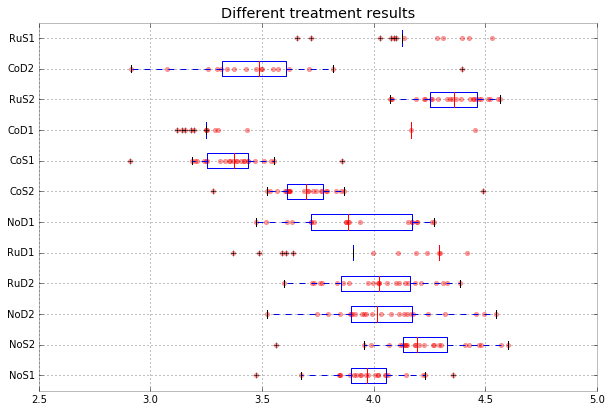

In [4]:
different_treatments = list(set(tp_df['treatment']))
different_responses = [tp_df.loc[tp_df['treatment'] == label]['response'].values for label in different_treatments]

figsize(10, 6.6)
plt.boxplot(different_responses, labels=different_treatments, vert=False);
plt.hold(True)
for idx, points in enumerate(different_responses, 1):
    plt.scatter(points, [idx]*len(points), alpha=0.4, color='r')
plt.title('Different treatment results');

###Ordinary Least Squares
In the last chapter, we *assumed* that we can use Ordinary Least Squares for inference, without questioning the implications we impose on our model by doing so.
There are a couple of things to keep in mind when we use OLS:
#### Exogeneity:
The errors in the regression should have the conditional mean zero:
$$
E[\epsilon | X] = 0
$$
The immediate consequence of the exogeneity assumption is that the errors have mean zero: $E[\epsilon] = 0$, and that the regressors are uncorrelated with the errors: $E[X^T \epsilon] = 0$.
The exogeneity assumption is critical for the OLS theory. If it holds then the regressor variables are called exogenous. If it doesn't, then those regressors that are correlated with the error term are called endogenous, and then the OLS estimates become invalid. In such case the method of instrumental variables may be used to carry out inference. 
#### Spherical errors:
$$
Var[\epsilon | X] = \sigma^2 I_n
$$
where $I_n$ is the identity matrix of size $n$, and $\sigma^2$ parameter which determines the variance of each observation, also implying that all observations have the same variance. It also implies that the errors are uncorrelated: $E[\epsilon_i \epsilon_j | X] = 0$, for all $i$ and $j$.
#### Which assumption does not hold?
We can see, by looking at the image displaying our data that our variances are not equaly distributed. This means that we cannot use OLS. What can we use?

In [5]:
# Let's separate the data by all control factors:
# NoS2: No - hormonal manipulation
#       S  - diet
#       2  - family
hormones = tadpole_data['var'].str[5:7]
diet = tadpole_data['var'].str[7:8]
family = tadpole_data['var'].str[8:9].convert_objects(convert_numeric=True)

tp_df_cat = pd.DataFrame({'hormones': hormones,
                      'diet': diet,
                      'family': family,
                      'response': response})
tp_df_cat[27:35]

,diet,family,hormones,response
27,D,1,Co,NaN
28,D,1,Co,NaN
29,D,1,Co,NaN
30,D,1,Co,4.166
31,S,1,Ru,4.429
32,S,1,Ru,3.655
33,S,1,Ru,4.137
34,S,1,Ru,4.080


In [7]:
# We want to make variables which we can use to
# make classification.
# This we cannot do with the hormons variable, since
# itself describes categories. Therefore, we'll create
# two new variables, Co and Ru, which will both be zero
# if the hormons has value 'No' - meaning nothing added.

from patsy import dmatrices
from sklearn import linear_model


tp_filtered = tp_df_cat[tp_df_cat['response'].notnull()]
# We will use patsy automagical creation of predictor
# matrices for categorical variables
outcome, predictors = dmatrices('response ~ hormones + diet + family', tp_filtered)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(predictors, outcome)

print 'Coefficients:   ', lin_regr.coef_
print 'Residuals:      ', np.mean((outcome - lin_regr.predict(predictors))**2)
print 'Variance score: ', lin_regr.score(predictors, outcome)

Coefficients:    [[ 0.          0.56152385  0.62730258  0.16685879  0.1990192 ]]
Residuals:       0.0614227193229
Variance score:  0.602083926442


###Model evaluation

Let's look at what SciKit offers for model evaluation. To quote them:

*"The sklearn.metrics module implements several loss, score, and utility functions to measure regression performance. Some of those have been enhanced to handle the multioutput case: mean_squared_error, mean_absolute_error, explained_variance_score and r2_score."*

####Explained variance score
$$
\textrm{explained variance} (y, \hat{y}) = 1 - \frac{Var(y - \hat{y})}{Var(y)}
$$

####Mean absolute error
The mean_absolute_error function computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss or $l_1$-norm loss.

$$
\textrm{MAE}(y, \hat{y}) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples} - 1}|y_i - \hat{y}_i|
$$

In [10]:
# Explained variance score:
import sklearn.metrics as metrics
from sklearn.feature_selection import f_regression

print 'Explained variance score: ', metrics.explained_variance_score(outcome, lin_regr.predict(predictors)), ' (out of max 1.)'
print 'Mean absolute error:      ', metrics.mean_absolute_error(outcome, lin_regr.predict(predictors))
print 'Mean squared error:       ', metrics.mean_squared_error(outcome, lin_regr.predict(predictors))
print 'R-squared statistic:      ', metrics.r2_score(outcome, lin_regr.predict(predictors))

Fs, ps = f_regression(predictors, outcome)
print
print lin_regr.coef_
print Fs
print ps

 Explained variance score:  0.602083926442  (out of max 1.)
Mean absolute error:       0.180471172781
Mean squared error:        0.0614227193229
R-squared statistic:       0.602083926442

[[ 0.          0.56152385  0.62730258  0.16685879  0.1990192 ]]
[         nan  23.15816797  45.65925472   4.03888583  22.74171744]
[             nan   2.65747369e-06   1.08141421e-10   4.55967755e-02
   3.23761046e-06]


In [12]:
# Let's try to add some interactions:

_model = '''response ~ hormones + diet + family + hormones:diet + hormones:family + diet:family + hormones:diet:family'''

outcome, predictors = dmatrices(_model, tp_filtered, return_type="dataframe")

int_regr = linear_model.LinearRegression()
int_regr.fit(predictors, outcome)

print 'Coefficients:             ', int_regr.coef_
print 'Variance score:           ', int_regr.score(predictors, outcome)
print 'Explained variance score: ', metrics.explained_variance_score(outcome, int_regr.predict(predictors)), ' (out of max 1.)'
print 'Mean absolute error:      ', metrics.mean_absolute_error(outcome, int_regr.predict(predictors))
print 'Mean squared error:       ', metrics.mean_squared_error(outcome, int_regr.predict(predictors))
print 'R-squared statistic:      ', metrics.r2_score(outcome, int_regr.predict(predictors))

 Coefficients:              [[ 0.          0.44861301  0.53392008 -0.29120492  0.25183396  0.38366324
   0.08071494  0.06318859  0.00345173  0.25878506 -0.15599541 -0.14057672]]
Variance score:            0.626376517987
Explained variance score:  0.626376517987  (out of max 1.)
Mean absolute error:       0.176643428299
Mean squared error:        0.0576728908258
R-squared statistic:       0.626376517987


In [13]:
# Feature selection

F, pval = f_regression(predictors, outcome)
for i, pred in enumerate(predictors):
    print '%40s: (%+.2f)\tF: %02.2f \tp-value: %e' % (pred, int_regr.coef_[0][i], F[i], pval[i])

                               Intercept: (+0.00)	F: nan 	p-value: nan
                          hormones[T.No]: (+0.45)	F: 23.16 	p-value: 2.657474e-06
                          hormones[T.Ru]: (+0.53)	F: 45.66 	p-value: 1.081414e-10
                               diet[T.S]: (-0.29)	F: 4.04 	p-value: 4.559678e-02
                hormones[T.No]:diet[T.S]: (+0.25)	F: 16.65 	p-value: 6.137992e-05
                hormones[T.Ru]:diet[T.S]: (+0.38)	F: 48.71 	p-value: 2.952965e-11
                                  family: (+0.08)	F: 22.74 	p-value: 3.237610e-06
                   hormones[T.No]:family: (+0.06)	F: 29.50 	p-value: 1.384351e-07
                   hormones[T.Ru]:family: (+0.00)	F: 48.16 	p-value: 3.731496e-11
                        diet[T.S]:family: (+0.26)	F: 15.83 	p-value: 9.196328e-05
         hormones[T.No]:diet[T.S]:family: (-0.16)	F: 21.42 	p-value: 6.087169e-06
         hormones[T.Ru]:diet[T.S]:family: (-0.14)	F: 51.46 	p-value: 9.274591e-12


In [15]:
alpha = 0.01
ls = linear_model.Lasso(alpha=alpha)
ls.fit(predictors, outcome)

print 'Coefficients:             ', ls.coef_
print 'Variance score:           ', ls.score(predictors, outcome)
print 'Explained variance score: ', metrics.explained_variance_score(outcome, ls.predict(predictors)), ' (out of max 1.)'
print 'Mean absolute error:      ', metrics.mean_absolute_error(outcome, ls.predict(predictors))
print 'Mean squared error:       ', metrics.mean_squared_error(outcome, ls.predict(predictors))
print 'R-squared statistic:      ', metrics.r2_score(outcome, ls.predict(predictors))

F, pval = f_regression(predictors, outcome)
ls.coef_
for i, pred in enumerate(predictors):
    print i
    print '%40s: (%+.2f)\tF: %02.2f \tp-value: %e' % (pred, ls.coef_[i], F[i], pval[i])

print
print 'Alpha: %.2f, Dimensionality reduction: %d' % (alpha, len(ls.coef_) - np.count_nonzero(ls.coef_))

 Coefficients:              [ 0.          0.13442594  0.20383558  0.          0.          0.          0.
  0.21771449  0.16916749  0.07262305  0.          0.07482266]
Variance score:            0.582381578264
Explained variance score:  0.582381578264  (out of max 1.)
Mean absolute error:       0.195139159669
Mean squared error:        0.0644639933065
R-squared statistic:       0.582381578264
0
                               Intercept: (+0.00)	F: nan 	p-value: nan
1
                          hormones[T.No]: (+0.13)	F: 23.16 	p-value: 2.657474e-06
2
                          hormones[T.Ru]: (+0.20)	F: 45.66 	p-value: 1.081414e-10
3
                               diet[T.S]: (+0.00)	F: 4.04 	p-value: 4.559678e-02
4
                hormones[T.No]:diet[T.S]: (+0.00)	F: 16.65 	p-value: 6.137992e-05
5
                hormones[T.Ru]:diet[T.S]: (+0.00)	F: 48.71 	p-value: 2.952965e-11
6
                                  family: (+0.00)	F: 22.74 	p-value: 3.237610e-06
7
                   hormones

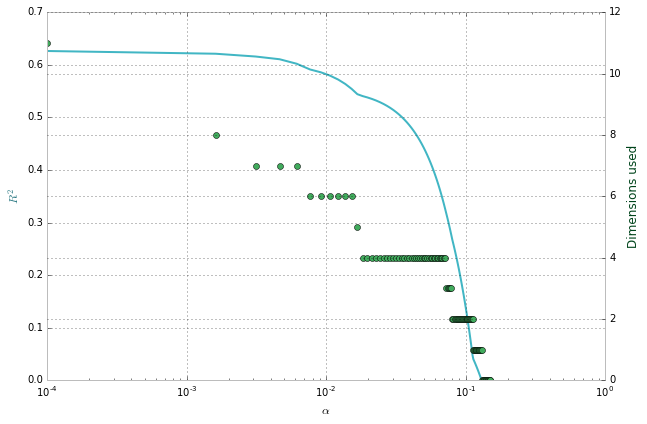

In [16]:
# Let's test dimensionality reduction and model usability
# We know that the maximum R-squared is 0.626376517987 
# (when we allow the most degrees of freedom)

r2_max = 0.626376517987
alphas = np.linspace(0.0001, 0.15, 100)
r2s = []
dims_used = []

for alpha in alphas:
    ls = linear_model.Lasso(alpha=alpha)
    ls.fit(predictors, outcome)
    r2s.append(metrics.r2_score(outcome, ls.predict(predictors)))
    dims_used.append(np.count_nonzero(ls.coef_))

fig, ax1 = plt.subplots()
ax1.semilogx(alphas, r2s, color='#41b6c4')
ax1.set_xlabel(r'$\alpha$')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel(r'$R^2$',  color='#2b7983')
#for tl in ax1.get_yticklabels():
#    tl.set_color('b')


ax2 = ax1.twinx()
ax2.semilogx(alphas, dims_used, 'o', color='#41ab5d')
ax2.set_ylabel('Dimensions used', color='#00441b');